In [5]:
# import xmltodict
# import xml.etree.ElementTree as ET
from project_settings import ExpConfig, DatasetConfig
from utils import copy_file,save_file,load_file,list_all_files
import re
import os
import numpy as np
import seaborn as sns
import pandas as pd

In [6]:
datasetConfig=DatasetConfig("AUSmini")

In [7]:
dir_path=datasetConfig.raw_path
# output_fn="datasets/summarization/summ.tsv"

In [9]:
sentence_pattern='<sentence id="s[0-9]*">(.*)</sentence>'
catchphrase_pattern='<catchphrase "id=c[0-9]*">(.*)</catchphrase>'

In [10]:

fpaths=list_all_files(dir_path)

# output_tsv(output_fn,fpaths,sentence_pattern,catchphrase_pattern)

In [11]:
fpaths

['../datasets/AUSmini_dataset/raw/corpus/fulltext/06_1473.xml',
 '../datasets/AUSmini_dataset/raw/corpus/fulltext/07_634.xml',
 '../datasets/AUSmini_dataset/raw/corpus/fulltext/06_396.xml',
 '../datasets/AUSmini_dataset/raw/corpus/fulltext/06_157.xml',
 '../datasets/AUSmini_dataset/raw/corpus/fulltext/06_143.xml',
 '../datasets/AUSmini_dataset/raw/corpus/fulltext/06_66.xml',
 '../datasets/AUSmini_dataset/raw/corpus/fulltext/06_1275.xml',
 '../datasets/AUSmini_dataset/raw/corpus/fulltext/06_1261.xml',
 '../datasets/AUSmini_dataset/raw/corpus/fulltext/07_1512.xml',
 '../datasets/AUSmini_dataset/raw/corpus/fulltext/06_1274.xml',
 '../datasets/AUSmini_dataset/raw/corpus/fulltext/06_67.xml',
 '../datasets/AUSmini_dataset/raw/corpus/fulltext/06_98.xml',
 '../datasets/AUSmini_dataset/raw/corpus/fulltext/06_195.xml',
 '../datasets/AUSmini_dataset/raw/corpus/fulltext/09_1533.xml',
 '../datasets/AUSmini_dataset/raw/corpus/fulltext/06_1670.xml',
 '../datasets/AUSmini_dataset/raw/corpus/fulltext/0

In [12]:
NUMBER_FILE1=len(fpaths)

In [13]:
case_collection={}
n=0
fnames=os.listdir(dir_path)
for fname in fnames:
    fpath=dir_path+fname
    with open(fpath,'r')as file:
        try:
            doc=file.read()
            sentences=re.findall(sentence_pattern, doc)
            catchphrases=re.findall(catchphrase_pattern, doc)
            case_collection[fname]={}
            case_collection[fname]["sentences"]=sentences
            case_collection[fname]["catchphrases"]=catchphrases
        except Exception as e:
            print(e)
            

'utf-8' codec can't decode byte 0xe9 in position 39: invalid continuation byte
'utf-8' codec can't decode byte 0xf7 in position 79: invalid start byte


In [14]:
NUMBER_FILE2=len(case_collection.keys())

In [15]:
nums_sentence=[]
nums_catchphrase=[]
for key in case_collection.keys():
    case_collection[key]["num_sentence"]=len(case_collection[key]["sentences"])
    case_collection[key]["num_catchphrase"]=len(case_collection[key]["catchphrases"])
    case_collection[key]["max_sent_length"]=max([len(sent) for sent in case_collection[key]["sentences"]])
    case_collection[key]["max_catch_length"]=max([len(sent) for sent in case_collection[key]["catchphrases"]])
    
    nums_sentence.append(len(case_collection[key]["sentences"]))
    nums_catchphrase.append(len(case_collection[key]["catchphrases"]))

In [16]:
case_collection_1={}
for key in case_collection.keys():
    if case_collection[key]["num_sentence"]<500 and case_collection[key]["num_sentence"]>10:
        case_collection_1[key]=case_collection[key]

In [17]:
NUMBER_FILE3=len(case_collection_1.keys())

In [18]:
case_collection_2={}
for key in case_collection_1.keys():
    if case_collection_1[key]["num_sentence"]<500 and case_collection_1[key]["num_sentence"]>10:
        case_collection_2[key]=case_collection_1[key]

In [19]:
NUMBER_FILE4=len(case_collection_2.keys())

In [20]:
case_collection_3={}
for key in case_collection_2.keys():
    if case_collection_2[key]["num_catchphrase"]<20 and case_collection_2[key]["num_sentence"]>2:
        case_collection_3[key]=case_collection_2[key]

In [21]:
NUMBER_FILE5=len(case_collection_3.keys())

In [22]:
case_collection_4={}
for key in case_collection_3.keys():
    if case_collection_3[key]["max_sent_length"]<1200: 
        case_collection_4[key]=case_collection_3[key]

In [23]:
NUMBER_FILE6=len(case_collection_4.keys())

In [24]:
NUMBER_FILE6/NUMBER_FILE1

0.8991935483870968

In [25]:
fname=sorted(list(case_collection_4.keys()))
item_to_n=dict(zip(fname,range(len(fname))))
n_to_item={v:k for k,v in item_to_n.items()}

In [30]:
# Construct splits
n=NUMBER_FILE6
n_tr, n_val, n_te = int(0.8 * n), int(0.1 * n), int(0.1 * n)
cur_n_tr, cur_n_val, cur_n_te = 0, 0, 0
split_to_item_to_nreviews = {'train': {}, 'val': {}, 'test': {}}
# In descending order of number of reviews per item
for i, (item, n) in enumerate(sorted(item_to_n.items())):
    # once every ten items, save to val / test if we haven't yet hit the target number
    if (i % 10 == 8) and (cur_n_val < n_val):
        split = 'val'
        cur_n_val += 1
    elif (i % 10 == 9) and (cur_n_te < n_te):
        split = 'test'
        cur_n_te += 1
    else:
        split = 'train'
        cur_n_tr += 1

    out_fp = os.path.join(datasetConfig.processed_path, '{}/{}'.format(split, item))
    in_fp=os.path.join(datasetConfig.raw_path, '{}'.format(item))
    copy_file(in_fp, out_fp, verbose=False)

    split_to_item_to_nreviews[split][item] = n
print('Number of train reviews: {} / {}'.format(cur_n_tr, n_tr))
print('Number of val reviews: {} / {}'.format(cur_n_val, n_val))
print('Number of test reviews: {} / {}'.format(cur_n_te, n_te))

# This file is used by AmazonPytorchDataset
for split, item_to_nreviews in split_to_item_to_nreviews.items():
    out_fp = os.path.join(datasetConfig.processed_path, '{}/item-to-n.json'.format(split))
    save_file(item_to_nreviews, out_fp)

Number of train reviews: 179 / 178
Number of val reviews: 22 / 22
Number of test reviews: 22 / 22


In [27]:
class AUSPytorchDataset():
    """
    Implements Pytorch Dataset
    One data point for model is n_docs reviews for one item. When training, we want to have batch_size items and
    sample n_docs reviews for each item. If a item has less than n_docs reviews, we sample with replacement
    (sampling with replacement as then you'll be summarizing repeated reviews, but this shouldn't happen right now
    as only items with a minimum number of reviews is used (50). These items and theiR reviews are selected
    in AmazonDataset.save_processed_splits().
    """
    def __init__(self, split=None, n_docs=None,
                 subset=None,
                 seed=0,
                 sample_reviews=True,
                 category=None,
                 item_max_reviews=None):
        """
        Args:
            split: str ('train', val', 'test')
            n_docs: int
            subset: float (Value in [0.0, 1.0]. If given, then dataset is truncated to subset of the businesses
            seed: int (set seed because we will be using np.random.choice to sample reviews if sample_reviews=True)
            sample_reviews: boolean
                - When True, __getitem_ will sample n_docs reviews for each item. The number of times a item appears
                in the dataset is dependent on uniform_items.
                - When False, each item will appear math.floor(number of reviews item has / n_docs) times
                so that almost every review is seen (with up to n_docs - 1 reviews not seen).
                    - Setting False is useful for (a) validation / test, and (b) simply iterating over all the reviews
                    (e.g. to build the vocabulary).
            item_max_reviews: int (maximum number of reviews a item can have)
                - This is used to remove outliers from the data. This is especially important if uniform_items=False,
                as there may be a large number of reviews in a training epoch coming from a single item. This also
                still matters when uniform_items=True, as items an outlier number of reviews will have reviews
                that are never sampled.
                - For the Amazon dataset, there are 11,870 items in the training set with at least 50 reviews
                no longer than 150 subtokens. The breakdown of the distribution in the training set is:
                    Percentile  |  percentile_n_reviews  |  n_items  |  total_revs
                    TODO?
        """
        self.split = split
        self.subset = subset
        self.sample_reviews = sample_reviews

        self.ds_conf = DatasetConfig('AUS')

        # Set random seed so that choice is always the same across experiments
        # Especially necessary for test set (along with shuffle=False in the DataLoader)
        np.random.seed(seed)
        item_to_nreviews = load_file(
            os.path.join(self.ds_conf.processed_path, '{}/item-to-nreviews.json'.format(split)))
        self.idx_to_item = {}
        
        idx = 0
        for item, n_reviews in item_to_nreviews.items():
            self.idx_to_item[idx] = item
            idx += 1


#     def __getitem__(self, idx):
#             # Map idx to item and load reviews
#             item = self.idx_to_item[idx]
#             fp = os.path.join(self.ds_conf.processed_path, '{}/{}'.format(self.split, item))
#             case_text = load_file(fp)

#             # Get reviews from item
#             if self.sample_reviews:
#                 if len(reviews) < self.n_docs:
#                     reviews = np.random.choice(reviews, size=self.n_docs, replace=True)
#                 else:
#                     reviews = np.random.choice(reviews, size=self.n_docs, replace=False)
#             else:
#                 start_idx = self.idx_to_item_startidx[idx]
#                 reviews = reviews[start_idx:start_idx + self.n_docs]

#             return texts, 

In [28]:
class AUSDataset():
    def __init__(self):
        self.name = 'AUS'
        self.conf = DatasetConfig('AUS')
        self.case_collection = None
#         self.subwordenc = load_file(self.conf.subwordenc_path)

#     @staticmethod
    def load_all_reviews(self):
        """
        Returns:
            reviews: list of dicts
            item_to_reviews: dict, key=str (item id), value=list of dicts
        """
        case_collection={}
        n=0
        fnames=os.listdir(self.conf.raw_path)
        for fname in fnames:
            fpath=self.conf.raw_path+fname
            try:
                case_collection[fname]=load_file(fpath)
            except Exception as e:
                print(e)

        return case_collection,len(fnames)

    def get_data_loader(self, split='train', subset=None,
                        batch_size=64, shuffle=True, num_workers=4):
        """
        Return iterator over specific split in dataset
        """
        ds = AUSPytorchDataset(split=split, subset=subset)
        loader = DataLoader(ds, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
        return loader

    ####################################
    #
    # One off functions
    #
    ####################################
    def save_processed_splits(self):
        """
        Save train, val, and test splits. Splits are across items (e.g. a item is either in train, val, or test).
        Iterates over all reviews in the original dataset. Tries to get close to a 80-10-10 split.
        Args:
            review_max_len: int (maximum length in subtokens a review can be)
            item_min_reviews: int (min number of reviews a item must have)
            out_dir: str (path to save splits to, e.g. datasets/amazon_dataset/proccessed/)
        """
        sent_max_len = self.conf.sent_max_len
        item_min_sent=self.conf.item_min_sent  
        item_max_sent=self.conf.item_max_sent 
        item_min_catch=self.conf.item_min_catch  
        item_max_catch=self.conf.item_max_catch  

        print('Saving processed splits')
        if self.case_collection is None:
            self.case_collection,num_file = self.load_all_reviews()
        
        case_collection_len=num_file
        
        for key in self.case_collection.keys():
            self.case_collection[key]["num_sentence"]=len(self.case_collection[key]["sentences"])
            self.case_collection[key]["num_catchphrase"]=len(self.case_collection[key]["catchphrases"])
            self.case_collection[key]["max_sent_length"]=max([len(sent) for sent in self.case_collection[key]["sentences"]])
            self.case_collection[key]["max_catch_length"]=max([len(sent) for sent in self.case_collection[key]["catchphrases"]])
    
        
        print('Filtering case having more than {} sentence or less than {} sentence '.format(item_max_sent,item_min_sent))
        case_collection_1={}
        for key in self.case_collection.keys():
            if self.case_collection[key]["num_sentence"]<item_max_sent and self.case_collection[key]["num_sentence"]>item_min_sent:
                case_collection_1[key]=self.case_collection[key]
        case_collection_len_1=len(case_collection_1)
        
        
        print('Filtering case having more than {} catchphrase or less than {} catchphrase '.format(item_max_catch,item_min_catch))
        case_collection_2={}
        for key in case_collection_1.keys():
            if case_collection_1[key]["num_catchphrase"]<item_max_catch and case_collection_1[key]["num_sentence"]>item_min_catch:
                case_collection_2[key]=case_collection_1[key]
                
        case_collection_len_2=len(case_collection_2)

        # # Note: we actually do more filtering in the Pytorch dataset class
        print('Filtering case having sentence longer than: {}'.format(sent_max_len))
        case_collection_3={}
        for key in case_collection_2.keys():
            if case_collection_2[key]["max_sent_length"]<sent_max_len: 
                case_collection_3[key]=case_collection_2[key]
        
        case_collection_len_3=len(case_collection_3)
        self.case_collection_len_final=case_collection_len_3

        # Calculate target amount of reviews per item
        print('Total number of reviews before filtering: {}'.format(case_collection_len))
        print('Total number of reviews after filtering: {}'.format(self.case_collection_len_final))


        
        self.case_collection=case_collection_3
        
        fname=sorted(list(self.case_collection.keys()))
        item_to_n=dict(zip(fname,range(len(fname))))
        n_to_item={v:k for k,v in item_to_n.items()}
        
        # Construct splits
        n=self.case_collection_len_final
        n_tr, n_val, n_te = int(0.8 * n), int(0.1 * n), int(0.1 * n)
        cur_n_tr, cur_n_val, cur_n_te = 0, 0, 0
        split_to_item_to_nreviews = {'train': {}, 'val': {}, 'test': {}}
        # In descending order of number of reviews per item
        for i, (item, n) in enumerate(sorted(item_to_n.items())):
            # once every ten items, save to val / test if we haven't yet hit the target number
            if (i % 10 == 8) and (cur_n_val < n_val):
                split = 'val'
                cur_n_val += 1
            elif (i % 10 == 9) and (cur_n_te < n_te):
                split = 'test'
                cur_n_te += 1
            else:
                split = 'train'
                cur_n_tr += 1

            out_fp = os.path.join(datasetConfig.processed_path, '{}/{}'.format(split, item))
            in_fp=os.path.join(datasetConfig.raw_path, '{}'.format(item))
            copy_file(in_fp, out_fp, verbose=False)

            split_to_item_to_nreviews[split][item] = n
        print('Number of train reviews: {} / {}'.format(cur_n_tr, n_tr))
        print('Number of val reviews: {} / {}'.format(cur_n_val, n_val))
        print('Number of test reviews: {} / {}'.format(cur_n_te, n_te))

        # This file is used by AmazonPytorchDataset
        for split, item_to_nreviews in split_to_item_to_nreviews.items():
            out_fp = os.path.join(datasetConfig.processed_path, '{}/item-to-n.json'.format(split))
            save_file(item_to_nreviews, out_fp)


## Test

In [53]:
ds=AUSDataset()

ds.save_processed_splits()

In [24]:
NUMBER_FILE6

3502

In [208]:
n_tr,n_val,n_te

(2801, 350, 350)

In [204]:
len(split_to_item_to_nreviews['train'])

2802

In [205]:
len(split_to_item_to_nreviews['test'])

350

In [206]:
len(split_to_item_to_nreviews['val'])

350

## Data analysis

In [14]:
case_collection={}
n=0
fnames=os.listdir(dir_path)
for fname in fnames:
    fpath=dir_path+fname
    with open(fpath,'r')as file:
        try:
            doc=file.read()
            sentences=re.findall(sentence_pattern, doc)
            catchphrases=re.findall(catchphrase_pattern, doc)
            case_collection[fname]={}
            case_collection[fname]["sentences"]=sentences
            case_collection[fname]["catchphrases"]=catchphrases
        except Exception as e:
            print(e)

'utf-8' codec can't decode byte 0xe9 in position 39: invalid continuation byte
'utf-8' codec can't decode byte 0xe9 in position 86: invalid continuation byte
'utf-8' codec can't decode byte 0xf6 in position 36: invalid start byte
'utf-8' codec can't decode byte 0xd6 in position 66: invalid continuation byte


In [15]:
sent_length=[]
catch_length=[]
for key in case_collection.keys():
    sent_length.append([  len(sent)  for sent in case_collection[key]["sentences"]])
    catch_length.append([  len(sent)  for sent in case_collection[key]["catchphrases"]])

In [16]:
sent_length_flat=[l for sents in sent_length for l in sents]
max_sent_length=[max(sents) for sents in sent_length]
catch_length_flat=[l for sents in catch_length for l in sents ]

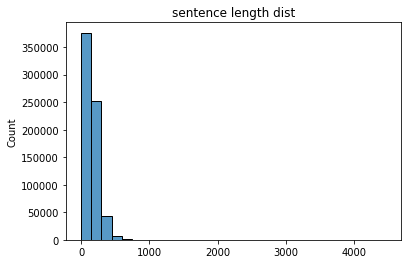

In [27]:
sns_plot=sns.histplot(sent_length_flat,bins=30).set_title("sentence length dist")
fig = sns_plot.get_figure()
savepath="./img/sentence_length_dist.png"
if not os.path.exists(savepath):
    fig.savefig(savepath)
    print("fig saved")

In [147]:
sum(np.array(max_sent_length)<1200)/len(max_sent_length)

0.9791559444158517

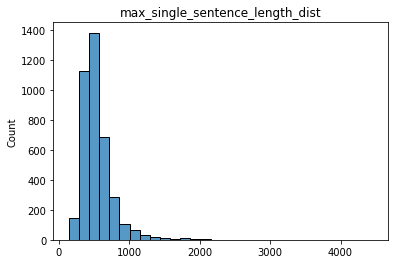

In [46]:
sns_plot=sns.histplot(max_sent_length,bins=30).set_title("max_single_sentence_length_dist")
fig = sns_plot.get_figure()
savepath="./img/max_single_sentence_length_dist.png"
if not os.path.exists(savepath):
    fig.savefig(savepath)
    print("fig saved")

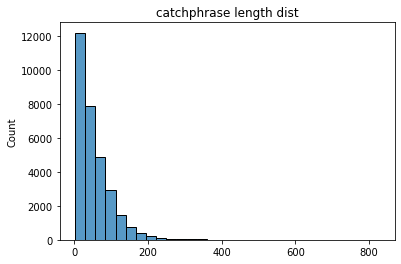

In [31]:
sns_plot=sns.histplot(catch_length_flat,bins=30).set_title("catchphrase length dist")
fig = sns_plot.get_figure()
savepath="./img/catchphrase_length_dist.png"
if not os.path.exists(savepath):
    fig.savefig(savepath)
    print("fig saved")

In [37]:
import numpy as np
nums_catchphrase=np.array(nums_catchphrase)
nums_sentence=np.array(nums_sentence)

In [38]:
np.mean(nums_catchphrase)

7.986618630983016

In [39]:
np.mean(nums_sentence)

175.28769943386516

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

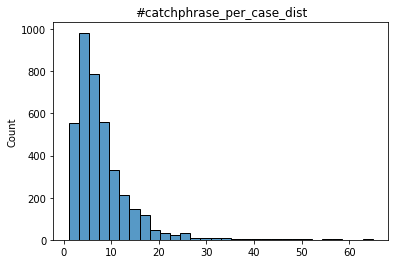

In [43]:
sns_plot=sns.histplot(nums_catchphrase,bins=30).set_title("#catchphrase_per_case_dist")
fig = sns_plot.get_figure()
savepath="./img/#catchphrase_per_case_dist.png"
if not os.path.exists(savepath):
    fig.savefig(savepath)
    print("fig saved")

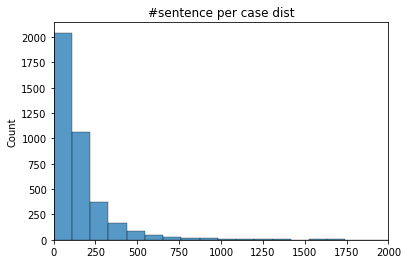

In [50]:
sns_plot=sns.histplot(nums_sentence,bins=100).set_title("#sentence per case dist")
fig = sns_plot.get_figure()
plt.xlim(0, 2000)
savepath="./img/#sentence_per_case_dist.png"
if not os.path.exists(savepath):
    fig.savefig(savepath)
    print("fig saved")

In [115]:
sum((nums_catchphrase<20) & (nums_catchphrase>=2))/len(nums_catchphrase)

0.9554812146165723

In [112]:
sum((nums_sentence<500) & (nums_sentence>=10))/len(nums_sentence)

0.9433865156973752

In [116]:
len(nums_catchphrase)

3886

Plot case description length

In [57]:
case_descriptions=[]
for key in case_collection.keys():
    case_descriptions.append(len(" ".join(case_collection[key]["sentences"])))

In [62]:
pd.DataFrame(case_descriptions,columns=["case description length"]).describe()

,case description length
count,3.886000e+03
mean,2.766677e+04
std,4.937713e+04
min,1.420000e+02
25%,8.921250e+03
50%,1.659550e+04
75%,3.122175e+04
max,1.671482e+06


# Data Analysis

In [2]:
import pandas as pd

In [7]:
summ=pd.read_csv(output_fn,sep='\t',header=None,names=["text","summ"])

In [8]:
len(summ)

3886

In [21]:
summ["text"].apply(len).describe()

count    3.886000e+03
mean     2.766677e+04
std      4.937713e+04
min      1.420000e+02
25%      8.921250e+03
50%      1.659550e+04
75%      3.122175e+04
max      1.671482e+06
Name: text, dtype: float64

In [22]:
summ["summ"].apply(len).describecribe()

count    3886.000000
mean      438.872105
std       405.346827
min        14.000000
25%       194.000000
50%       328.000000
75%       557.750000
max      6687.000000
Name: summ, dtype: float64

In [68]:
with open("/Users/saibo/tmp/vocab.txt","r") as file:
    l=file.read().splitlines()

In [72]:
vocab=pd.DataFrame([len(token) for token in l])

In [73]:
vocab.describe()

,0
count,30522.000000
mean,6.584955
std,2.483049
min,1.000000
25%,5.000000
50%,6.000000
75%,8.000000
max,18.000000


In [74]:
np.median(vocab)

6.0